In [1]:
import os
import cv2

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def read_flo_file(filename):
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None
    if 202021.25 != magic:
        print('Magic number incorrect. Invalid .flo file')
    else:
        w = np.fromfile(f, np.int32, count=1)
        h = np.fromfile(f, np.int32, count=1)
        data2d = np.fromfile(f, np.float32, count=int(2 * w * h))
        data2d = np.resize(data2d, (h[0], w[0], 2))
    f.close()
    return data2d

In [17]:
def flow2rgb(flow_map, max_value):
    flow_map_np = flow_map.detach().cpu().numpy()
    _, h, w = flow_map_np.shape
    flow_map_np[:,(flow_map_np[0] == 0) & (flow_map_np[1] == 0)] = float('nan')
    rgb_map = np.ones((3,h,w)).astype(np.float32)
    if max_value is not None:
        normalized_flow_map = flow_map_np / max_value
    else:
        normalized_flow_map = flow_map_np / (np.abs(flow_map_np).max())
    rgb_map[0] += normalized_flow_map[0]
    rgb_map[1] -= 0.5*(normalized_flow_map[0] + normalized_flow_map[1])
    rgb_map[2] += normalized_flow_map[1]
    return rgb_map.clip(0,1)

In [20]:
import torch

In [24]:
import sys
sys.path.insert(0, './flow_tool/')
import flowlib as fl

/mnt/lustre/dingmingyu/software/python3/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/lustre/dingmingyu/software/python3/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


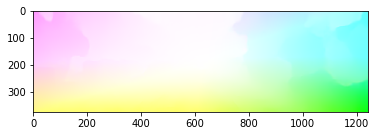

In [191]:
a = '/mnt/lustre/dingmingyu/Research/geo/pytorch-pwc/output_kitti_1/991.flo'
flow = read_flo_file(a)
flow[:,:,0] = flow[:,:,0].astype(np.float32)/1242
flow[:,:,1] = flow[:,:,1].astype(np.float32)/375
flow_torch = torch.from_numpy(flow.transpose((2,0,1)))
plt.imshow(flow2rgb(flow_torch, None).transpose((1,2,0)))

In [205]:
img = cv2.imread('/mnt/lustre/dingmingyu/Research/3dbbox/3D-Bbox/Kitti/training/image_2/000991.png').astype(np.float32)/255
pre = cv2.imread('/mnt/lustre/dingmingyu/Research/3dbbox/3D-Bbox/Kitti/training/prev_2/000991_01.png').astype(np.float32)/255

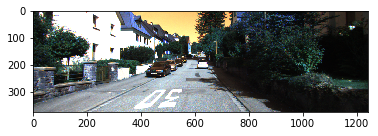

In [145]:
plt.imshow(img)

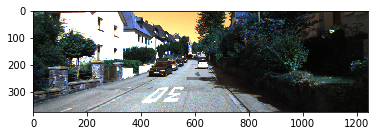

In [146]:
plt.imshow(pre)

In [147]:

import torch.nn.functional as F
def flow_warp(x, flow, padding_mode='zeros'):
    """Warp an image or feature map with optical flow
    Args:
        x (Tensor): size (n, c, h, w)
        flow (Tensor): size (n, 2, h, w), values range from -1 to 1 (relevant to image width or height)
        padding_mode (str): 'zeros' or 'border'

    Returns:
        Tensor: warped image or feature map
    """
    assert x.size()[-2:] == flow.size()[-2:]
    n, _, h, w = x.size()
    x_ = torch.arange(w).view(1, -1).expand(h, -1)
    y_ = torch.arange(h).view(-1, 1).expand(-1, w)
    grid = torch.stack([x_, y_], dim=0).float()
    if x.is_cuda:
        grid = grid.cuda()
    grid = grid.unsqueeze(0).expand(n, -1, -1, -1)
    #grid += flow    # for flow ont in [-1,1]
    #grid[:,0,:,:] = 2.0*grid[:,0,:,:]/max(w-1,1)-1.0
    #grid[:,1,:,:] = 2.0*grid[:,1,:,:]/max(h-1,1)-1.0
    
    grid[:, 0, :, :] = 2 * grid[:, 0, :, :] / (w - 1) - 1
    grid[:, 1, :, :] = 2 * grid[:, 1, :, :] / (h - 1) - 1
    #grid = Variable(grid)
    grid += 2 * flow
    grid = grid.permute(0, 2, 3, 1)
    mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
    mask = F.grid_sample(mask, grid)
    mask[mask<0.9999] = 0
    mask[mask>0] = 1
    return F.grid_sample(x, grid, padding_mode=padding_mode), mask

In [148]:
_, h, w = img_torch
box_2d


[(416, 187), (517, 248)]

In [193]:
416 + flow[187,416,0]*1242

422.75164553523064

In [194]:
187 + flow[187,416,1]*375

187.14741075210623

In [195]:
517 + flow[248,517,0]*1242

522.5401608822867

In [196]:
248 + flow[248,517,1]*375

244.82780483271927

In [211]:
plot_2d_box(pre, [(423,187),(523,245)])
plot_2d_box(img, [(416,187),(517,248)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


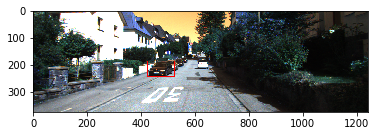

In [199]:
plt.imshow(pre)

In [200]:
img_torch = torch.from_numpy(img.transpose(2,0,1))

In [201]:
pre_torch = torch.from_numpy(pre.transpose(2,0,1))

In [202]:
warp_torch, mask_torch= flow_warp(pre_torch.unsqueeze(0).cuda() , flow_torch.unsqueeze(0).cuda(), padding_mode='zeros')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


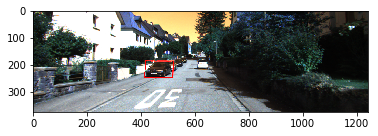

In [203]:
plt.imshow(warp_torch.cpu().numpy()[0].transpose((1,2,0)))

In [207]:
warp = warp_torch.cpu().numpy()[0].transpose((1,2,0))
plot_2d_box(warp, [(416,187),(517,248)])

TypeError: Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


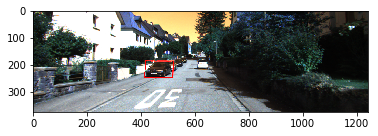

In [208]:
plt.imshow(warp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


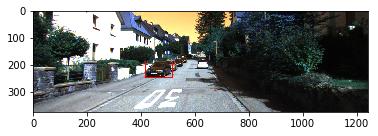

In [213]:
plt.imshow(img)

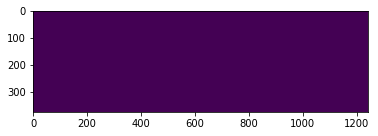

In [172]:
plt.imshow(mask_torch.squeeze(0).cpu().numpy()[0])

In [55]:
def format_label(line):
    line = line[:-1].split(' ')

    Class = line[0]

    for i in range(1, len(line)):
        line[i] = float(line[i])

    Alpha = line[3] # what we will be regressing
    Ry = line[14]
    top_left = (int(round(line[4])), int(round(line[5])))
    bottom_right = (int(round(line[6])), int(round(line[7])))
    Box_2D = [top_left, bottom_right]


    return Box_2D

torch.Size([1, 3, 375, 1242])

In [74]:
from enum import Enum


class cv_colors(Enum):
    RED = (0,0,255)
    GREEN = (0,255,0)
    BLUE = (255,0,0)
    PURPLE = (247,44,200)
    ORANGE = (44,162,247)
    MINT = (239,255,66)
    YELLOW = (2,255,250)

In [73]:
def create_2d_box(box_2d):
    corner1_2d = box_2d[0]
    corner2_2d = box_2d[1]

    pt1 = corner1_2d
    pt2 = (corner1_2d[0], corner2_2d[1])
    pt3 = corner2_2d
    pt4 = (corner2_2d[0], corner1_2d[1])

    return pt1, pt2, pt3, pt4

def plot_2d_box(img, box_2d):
    # create a square from the corners
    pt1, pt2, pt3, pt4 = create_2d_box(box_2d)

    # plot the 2d box
    cv2.line(img, pt1, pt2, cv_colors.BLUE.value, 2)
    cv2.line(img, pt2, pt3, cv_colors.BLUE.value, 2)
    cv2.line(img, pt3, pt4, cv_colors.BLUE.value, 2)
    cv2.line(img, pt4, pt1, cv_colors.BLUE.value, 2)

In [91]:
box_2d = format_label(open('/mnt/lustre/dingmingyu/Research/3dbbox/3D-Bbox/Kitti/training/label_2/000991.txt').readlines()[1])

In [92]:
plot_2d_box(img, box_2d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


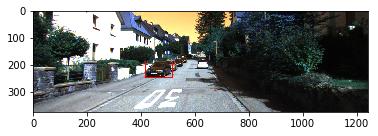

In [93]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


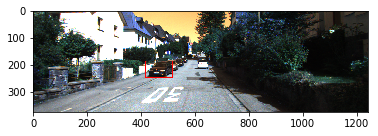

In [86]:
plt.imshow(pre)